Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install systole

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from systole.plots import plot_raw
from systole.detection import ecg_peaks
from systole import import_dataset1, import_ppg
from systole.utils import input_conversion

from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

sns.set_context('talk')

Loading BokehJS ...

# Cardiac signal analysis

This tutorial notebook introduces two commonly used methods to record cardiac activity: electrocardiography (ECG) and photoplethysmography (PPG).

---
## Electrocardiography (ECG)

[Electrocardiography](https://en.wikipedia.org/wiki/Electrocardiography) (ECG or EKG) is the process of recording the small electrical changes that are a consequence of cardiac muscle depolarization followed by repolarization during each cardiac cycle (i.e., the heartbeat). It is important to note that the conventional ECG performed in a clinical context requires placing ten electrodes on the patient's limbs and the surface of the chest. Electrical potentials are then measured from 12 different angles to give a better representation of the 3 main components of the cardiac cycle (see panel **b.** bellow): the **P wave**, the **QRS component**, and the **T wave**. However, in the context of psychological research, the shape of each of these components and their intervals is of lesser interest. The focus is instead on the heart rate and the heart rate variability, which essentially requires the estimation of the R-R intervals, and therefore the detection of the R peaks. A 3-electrode system is then often preferred over more complex setups (see panel **a.** bellow).

<p align='center'><img src='https://github.com/embodied-computation-group/systole/raw/dev/source/images/ecg.png'/></p>

### Importing Example ECG dataset

To illustrate the analysis of ECG signals, we will use a dataset containing ECG and respiratory recording from a healthy participant. These data were acquired concurrently with the paradigm described in Legrand et al. (2020), where subjects were asked to memorize and later inhibit/suppress images [1] and ECG was recorded using a standard 3-point electrode montage. You can load this data set with Systole directly using `systole.import_dataset1()`. As this dataset contains many modalities (ECG, respiration, EDA), you can decide to download only some of them to save time. This is what we are doing with the `modalities` argument.

In [4]:
ecg_df = import_dataset1(modalities=['ECG'], disable=True)

The resulting variable (`ecg_df`) is a [Pandas](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) DataFrame. Using basic Pandas utilities, quickly check the columns names and datatypes by showing the first 5 rows using `head()`.

In [5]:
ecg_df.head()

,ecg,time
0,3.299866,0.000
1,3.263855,0.001
2,3.238525,0.002
3,3.224487,0.003
4,3.218079,0.004


Here, the ECG signal is encoded in the `ecg` collumn. The `time` column encodes the acquisition time in seconds. We can see here that the sampling rate is 1000 Hz. We can also have a quick look at the ECG signal using the built-in `plot()` method (here showing only a slice of 30 seconds for clarity).

<AxesSubplot:xlabel='time'>

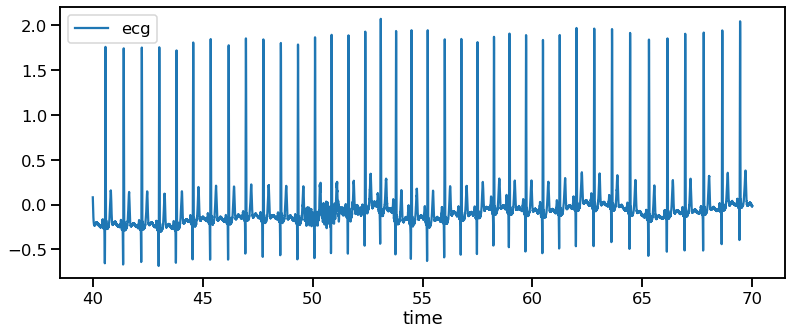

In [6]:
ecg_df[ecg_df.time.between(40, 70)].plot(x='time', y='ecg', figsize=(13, 5))

### R peaks detection

Plotting the raw ECG signal is an important step if we want to check the quality of the recording, but it will give very little information in itself regarding the subtle change in the dynamic of cardiac activity that might interact with cognitive processes. If we want more details, we need to analyze the heart rate frequency, and this is done by estimating the time interval between two heartbeats. A heartbeat is not a discrete process though and results from a sequence of characteristic biomechanical activities, each giving a particular electrical waveform (see panel **b.** above). But we can see in the recording that one component (the R peak, that corresponds to the ventricular depolarization and the ejection of the blood from the cardiac cavities) clearly emerges from the noise and can be systematically detected with great precision. For these reasons, the R peak is often used as the temporal index of heartbeats.

[Systole](https://systole-docs.github.io/) offers different algorithms for R peaks detection that will be discussed in the next section. Here we will use an illustration using the [Pan-Tompkins algorithm](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm). First, let's select a subsample of the signal.

In [7]:
signal = ecg_df[ecg_df.time.between(500, 530)].ecg.to_numpy()  # Select only 30 seconds of recording

Then, we use the `systole.detection.ecg_peaks()` function to this sample by providing the algorithm and method we want to use.

In [8]:
signal, peaks = ecg_peaks(signal, method='pan-tompkins', sfreq=1000)

This function will output two 1d Numpy arrays: **1)** the resampled `signal` (this only matters if the sampling frequency of the input signal was different from the standard 1000 Hz that is the default of many Systole functions), and **2)** a `peaks` vector. The peaks vector has the same size as the input signal and is a boolean array (i.e., it only contains 0/False and 1/True logical values). The R peaks are encoded as 1 and the rest of the signal is set to 0. This vector can then be used to plot the detected R peaks on the input signal (panel **1** below). We can also use this vector to compute the distance between each R peaks (the R-R interval, see panel **2** below), which is used to measure the instantaneous heart rate (see panel **3** below).

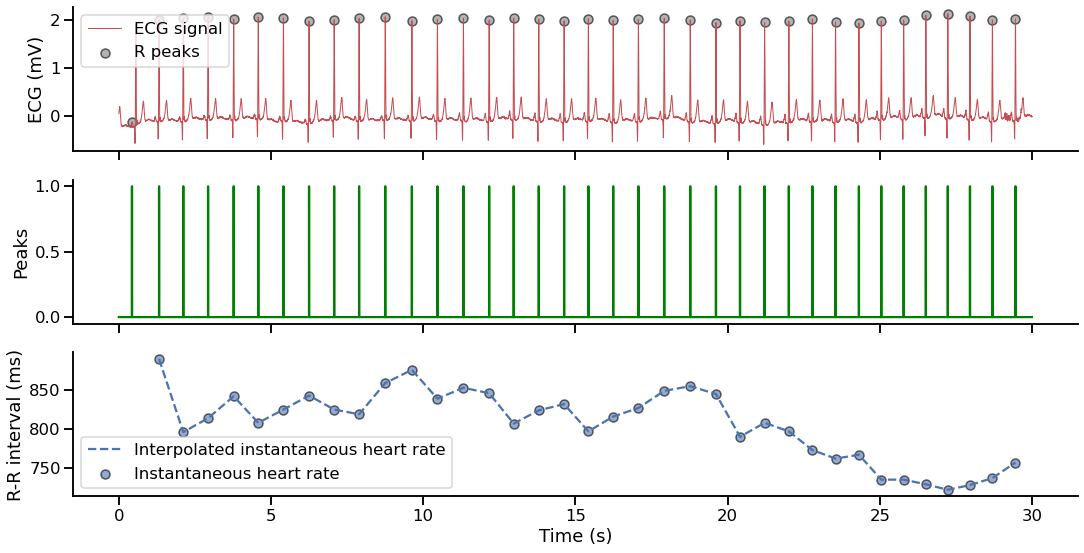

In [9]:
time = np.arange(0, len(signal))/1000  # Create a time vector (seconds)

fig, axs = plt.subplots(3, 1, figsize=(18, 9), sharex=True)

# Raw ECG signal and R peaks
# --------------------------
axs[0].plot(time, signal, color='#c44e52', linewidth=1, label='ECG signal')
axs[0].scatter(time[peaks], signal[peaks], color='gray', edgecolor="k", alpha=.6, label="R peaks")
axs[0].set_ylabel('ECG (mV)')
axs[0].legend()

# The boolean peaks vector
# ------------------------
axs[1].plot(time, peaks, color='g')
axs[1].set_ylabel('Peaks')

# The instantaneous heart rate activity
# -------------------------------------
axs[2].plot(time[peaks][1:], np.diff(np.where(peaks)[0]), color='#4c72b0', linestyle='--', label="Interpolated instantaneous heart rate")
axs[2].scatter(time[peaks][1:], np.diff(np.where(peaks)[0]), color='#4c72b0', edgecolor="k", alpha=.6, label="Instantaneous heart rate")
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('R-R interval (ms)')
axs[2].legend()

sns.despine()

**A note on the data format:** [Systole](https://systole-docs.github.io/) will output a boolean peaks vector after detection by default. We found this approach more intuitive as the time series keeps the same size and it can easier to slice it according to events observed in another signal (e.g the respiration or the stim channel). However, the same information can also be encoded as peaks indexes (`peaks_idx`), referring to the sample number where the R peaks were detected, or directly as RR-intervals expressed in seconds or milliseconds (`rr_s` and `rr_ms` respectively). Other packages will use different formats as default for encoding and you might have to convert your inputs. This can be done easily using `systole.utils.input_conversion`, which will let you convert your data accordingly.

In [10]:
# From boolean peaks vector to peaks indexs
peaks_idx = input_conversion(peaks, input_type="peaks", output_type="peaks_idx")
peaks_idx

array([  431,  1321,  2117,  2931,  3773,  4581,  5406,  6249,  7074,
        7893,  8752,  9628, 10467, 11320, 12166, 12973, 13797, 14629,
       15426, 16242, 17069, 17918, 18773, 19618, 20408, 21216, 22013,
       22786, 23548, 24315, 25050, 25785, 26514, 27236, 27964, 28701,
       29458], dtype=int64)

In [11]:
# From peaks index to R-R intervals (seconds)
rr_s = input_conversion(peaks_idx, input_type="peaks_idx", output_type="rr_s")
rr_s

array([0.89 , 0.796, 0.814, 0.842, 0.808, 0.825, 0.843, 0.825, 0.819,
       0.859, 0.876, 0.839, 0.853, 0.846, 0.807, 0.824, 0.832, 0.797,
       0.816, 0.827, 0.849, 0.855, 0.845, 0.79 , 0.808, 0.797, 0.773,
       0.762, 0.767, 0.735, 0.735, 0.729, 0.722, 0.728, 0.737, 0.757])

In [12]:
# From R-R intervals (seconds) to R-R intervals (miliseconds)
rr_ms = input_conversion(rr_s, input_type="rr_s", output_type="rr_ms")
rr_ms

array([890., 796., 814., 842., 808., 825., 843., 825., 819., 859., 876.,
       839., 853., 846., 807., 824., 832., 797., 816., 827., 849., 855.,
       845., 790., 808., 797., 773., 762., 767., 735., 735., 729., 722.,
       728., 737., 757.])

### R-R intervals and beats per minute

As we have seen above, the R-R intervals are simply the time elapsed between one R peak and the next, corresponding to one complete cardiac cycle. Of course, this value is not stable across time, it is updated at each heartbeat, and these beat to beat values can then be transformed to a continuous vector encoding the instantaneous heart rate, expressed in beats per minute (BPM). The conversion from RR-interval in milliseconds to BPM is done using the following formula:
$$BPM = \frac{60000}{RR} $$

It is worth noting that the conversion from RR intervals to beats per minute involves a non-linear function of the form $\frac{1}{x}$. This should be taken into account when interpreting the amplitude of changes in heart rate, e.g., when comparing an experimental condition to baseline. For example, increasing the heart rate from 40 to 45 bpm diminishes the RR interval by approximately 167ms, while increasing the heart rate from 120 to 125 bpm decrease RR intervals by only 20ms (see graph below).

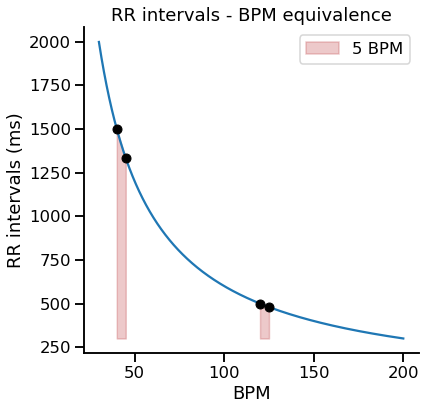

In [13]:
rr = np.arange(300, 2000, 2)
plt.figure(figsize=(6, 6))
plt.plot(60000/rr, rr)

plt.fill_between(x=np.arange(40, 46), y1=60000/np.arange(40, 46), y2=300, alpha=.3, color='#c44e52')
plt.plot([40, 45], 60000/np.array([40, 45]), 'ko')

plt.fill_between(x=np.arange(120, 126), y1=60000/np.arange(120, 126), y2=300, alpha=.3, color='#c44e52', label='5 BPM')
plt.plot([120, 125], 60000/np.array([120, 125]), 'ko')

plt.xlabel('BPM')
plt.ylabel('RR intervals (ms)')
plt.title('RR intervals - BPM equivalence')
plt.legend()
sns.despine()

### Interactive visualization

R peaks detection and the conversion of the peak to peaks intervals into interpretable heart rate measures are the two building blocks of cardiac signal analysis. [Systole](https://systole-docs.github.io/) lets you execute and plot these processes in one line of code using the `systole.plots.plot_raw()` function. The `plots` module contains several plotting utilities for standard visualization processes in cardiac signal analysis. Each function support two plotting backends: [Matplotlib](https://matplotlib.org/) for static graphs and [Bokeh](https://docs.bokeh.org/en/latest/index.html), for interactive graphs. In the following tutorials, we will use Bokeh as a default rendering backend (see the `backend` argument below). However, it is always possible to plot the same figure using Matplotlib if you do not change this argument. The other arguments here simply specify the modality of the recording, which can currently be `ECG` or `PPG`, and the algorithm to use for R peaks detection. Because we would like to have the Raw ECG signal stacked with the estimated instantaneous heart rate frequency, we set `show_heart_rate` to `True`.

In [14]:
# Extract 100 seconds of recording for illustration
signal = ecg_df[ecg_df.time.between(500, 600)].ecg.to_numpy()

In [15]:
show(
    plot_raw(signal, modality='ecg', ecg_method='pan-tompkins', show_heart_rate=True, backend='bokeh')
)

We can see that the Pan-Tompkins algorithm does a good job at detecting the QRS components. We will see in the next tutorial that this algorithm is a great starting point for R peaks detection. Furthermore, looking at the R-R intervals time series, it is also obvious that the heart rate is not constant across time but oscillates according to both higher and lower frequencies. We will investigate these variations later in the section dedicated to heart rate variability.

---
## Photoplethysmography (PPG)

[Photoplethysmography](https://en.wikipedia.org/wiki/Photoplethysmogram) is a non-invasive method used to measure the change of blood volume. This method can be used in addition to or as a replacement for electrocardiography, depending on the exact experimental design or research question. It can be more sensitive to movement, and - depending on the sampling rate - more or less suitable for studying heart rate variability. The PPG signal is characterized by a main **systolic peak**, often (but not always) followed by a smaller **diastolic peak** before the signal returns to origin. The lower point between the systolic and diastolic peak is the **dicrotic notch**. The systolic peaks correspond to the moment where the volume of blood in the blood vessel suddenly increases due to the pressure of the heart contraction. The blood volume measured at the periphery does not change immediately after the cardiac systole, but rather with a delay varying depending on physiological parameters. For this reason, the systolic peak and the R peak are not concomitant but rather delayed, the systolic peak often occurring after the T wave of the ECG. The delay between the R wave on the ECG and the systolic peak can vary between individuals and across time in the same individual according to a variety of physiological parameters.

<p align='center'><img src='https://github.com/embodied-computation-group/systole/raw/dev/source/images/pulseOximeter.png'/></p>

Let's first import an example dataset from [Systole](https://systole-docs.github.io/). This time series represent a PPG recording from pulse oximeter in a healthy young participant. The sampling rate is 75 Hz.

In [16]:
ppg = import_ppg()

### Systolic peak detection

Like for ECG, we can use this signal to estimate the time interval between two heartbeats and assess cardiac activity. The main information of interest we can retrieve from the PPG signal is the timing of the occurrence of the systolic peak. The timing of these events is tightly linked to the occurrence of the R wave (although with a slightly variable delay), and we can use the peak vector resulting from this analysis the same way we analyze the RR interval time series with an ECG signal. Because we are not measuring the heart rate strictly speaking, but the pulse at the periphery of the body, this approach is often termed **pulse rate variability** to distinguish from the heart rate variability that builds on the ECG signal.

We can plot the PPG time serie and visualize peak detection and the inter-beat intervals time series using the `plot_raw` function.

In [17]:
show(
    plot_raw(ppg, modality='ppg', backend='bokeh')
)

This concludes our introduction to the basic elements of cardiac signal processing using the Systole package. In the next tutorial, we will take a closer examination of how Systole can be used to extract different parameters relating to heart-rate variability. 

**References**

**[1]** Legrand, N., Etard, O., Vandevelde, A., Pierre, M., Viader, F., Clochon, P., Doidy, F., Peschanski, D., Eustache, F., & Gagnepain, P. (2020). Long-term modulation of cardiac activity induced by inhibitory control over emotional memories. Scientific Reports, 10(1). https://doi.org/10.1038/s41598-020-71858-2 **We will use one example recording throughout the tutorial that was acquired using this paradigm**.

**Going further**

Mejía-Mejía E., Allen J., Budidha K., El-Hajj C., Kyriacou P.A. and Charlton P.H., Photoplethysmography Signal Processing and Synthesis. In Photoplethysmography; Kyriacou, P.A., Allen, J., Eds.; Elsevier, 2021. **Book chapter providing an extensive review of photoplethysmogram signal processing methods.**